# Imports and declarations

In [1]:
import pymupdf
import logging
import glob
import datetime
import os
from pathlib import Path
from pymupdf import Point, Matrix, Rect, Quad

class MyRect(Rect):
    def expand_rect(self, pix=18):
        return MyRect(self[0] - pix, self[1] - pix, self[2] + pix, self[3] + pix)
    
    def center(self):
        return Point((self[0] + self[2]) / 2, (self[1] + self[3]) / 2)

    def fits_on_printer_pater(self):
        return ((min(self.width, self.height) < 7.5 * 72) and (max(self.width, self.height) < 10 * 72))
    
def merge_overlapping_rects(list_of_rects):
    final_rects = [list_of_rects.pop()]

    while len(list_of_rects) > 0:
        current_rect = list_of_rects.pop()
        sorted = False
        for final_rect in final_rects:
            if final_rect.intersects(current_rect):
                final_rect = final_rect.include_rect(current_rect)
                sorted = True
        if not sorted:
            final_rects.append(current_rect)
    
    return final_rects

In [2]:
cwd = Path.cwd()

file_path = list(cwd.glob("*.pdf"))[-1]

doc = pymupdf.open(file_path)

39

In [51]:
total_doc_screenshots = []

for page_number in range(doc.page_count):
    page = doc[page_number]
    annots = list(page.annots())
    print(page.number)
    print(total_doc_screenshots)

    # for annot in annots:
    if len(annots) > 0:
        print(f"pg. {page.number + 1} - {annots[0].info['content']=}")
        
        # page.get_pixmap().pil_image()
        rect_groups = [[annots[0]]]

        # Group together annotations that are close to each other
        for i in range(1,len(annots)):
            annot = annots[i]
            added_to_group = False
            annot_rect = MyRect(annot.apn_bbox)

            for j in range(len(rect_groups)):
                group = rect_groups[j]
                for k in range(len(group)):
                    rect = MyRect(group[k].apn_bbox)

                    if annot_rect.expand_rect().intersects(rect.expand_rect()):
                        group.append(annot)
                        k = len(group) + 1
                        j = len(rect_groups) + 10
            
            if j != len(rect_groups) + 10:
                rect_groups.append([annot])

        # Make boundary rects that include all annots within their boundaries
        boundary_rects = []
        for rect_group in rect_groups:
            surrounding_rect = MyRect(rect_group[0].apn_bbox)

            if len(rect_group) > 0:
                for i in range(1, len(rect_group)):
                    surrounding_rect = surrounding_rect.include_rect(rect_group[i].apn_bbox)
                
            boundary_rects.append(surrounding_rect.expand_rect())

        # Make a really immature grouping of annotations
        screenshot_rects = boundary_rects.copy()

        for i in range(30):
            for j in range(len(screenshot_rects)):
                if screenshot_rects[j].fits_on_printer_pater():
                    screenshot_rects[j] = screenshot_rects[j].expand_rect(pix=18)
            
            screenshot_rects = merge_overlapping_rects(screenshot_rects)
        print(total_doc_screenshots)

        final_number = len(screenshot_rects)

        screenshot_rects = boundary_rects.copy()
        while len(screenshot_rects) > final_number:
            
            for j in range(len(screenshot_rects)):
                if screenshot_rects[j].fits_on_printer_pater():
                    screenshot_rects[j] = screenshot_rects[j].expand_rect(pix=3).intersect(page.rect)
            
            screenshot_rects = merge_overlapping_rects(screenshot_rects)
        print(total_doc_screenshots)

        # Make a dictionary containing all the annotations and key information for this page
        print(screenshot_rects)
        screenshot_dict = {rect: {"annot_ids": [], "authors": set(), "last_modified": -1, "portrait": True} for rect in screenshot_rects}
        print(total_doc_screenshots)

        for annot in annots:
            for screenshot_rect in screenshot_dict.keys():
                if annot.apn_bbox.intersects(screenshot_rect):
                    screenshot_dict[screenshot_rect]["annot_ids"].append(annot.info['id'])
                    screenshot_dict[screenshot_rect]["authors"].add(annot.info['title'])

                    modif_time = datetime.datetime.strptime(annot.info['modDate'].replace("'", ""), r"D:%Y%m%d%H%M%S%z")

                    if screenshot_dict[screenshot_rect]["last_modified"] == -1 or modif_time.timestamp() > screenshot_dict[screenshot_rect]["last_modified"].timestamp():
                        screenshot_dict[screenshot_rect]["last_modified"] = modif_time

                    if screenshot_rect.width > screenshot_rect.height:
                        screenshot_dict[screenshot_rect]["portrait"] = False

        total_doc_screenshots.append((page.get_label(), screenshot_dict))
        print(total_doc_screenshots)

0
[]
1
[]
2
[]
pg. 3 - annots[0].info['content']=''
[]
[]
[Rect(1036.741455078125, 790.3683471679688, 1670.6544189453125, 1497.283935546875), Rect(1476.466552734375, 0.0, 2175.332763671875, 254.994384765625)]
[]
[('E0.06-F - ELECTRICAL SCHEDULES\\000', {Rect(1036.741455078125, 790.3683471679688, 1670.6544189453125, 1497.283935546875): {'annot_ids': ['QFDTTKAXVZWJKZSN', 'STUBNLHKQXSEUKQX', 'XQVCDEGWOXOMXVNG', 'RCBZIHWKQHJZQJEQ', 'BVIRMSYOOJDNFMOB', 'XUONAUONMOAWRWFU'], 'authors': {'MattNielsen'}, 'last_modified': datetime.datetime(2025, 12, 16, 13, 15, 23, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=57600))), 'portrait': True}, Rect(1476.466552734375, 0.0, 2175.332763671875, 254.994384765625): {'annot_ids': ['PQODMJDKUJWVRRHP', 'LGYHLCUHGHGRCJPP'], 'authors': {'MattNielsen'}, 'last_modified': datetime.datetime(2025, 12, 16, 13, 15, 23, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=57600))), 'portrait': False}})]
3
[('E0.06-F - ELECTRICAL SCHEDULES\\000', 

In [47]:
# Example: First annotation is on page 3:
page = doc[9]

In [48]:
annots = list(page.annots())

for annot in annots:
    print(annot.info['content'])
    
    pass

annot.info


Why two sided?


{'content': 'Why two sided?',
 'name': '',
 'title': 'MattNielsen',
 'creationDate': "D:20251216131624-08'00'",
 'modDate': "D:20251216131624-08'00'",
 'subject': 'Callout',
 'id': 'KHCJPZVBDEHMPJAF'}

'FreeText' annotation on page 9 of c:\Users\BenjaminAnderson\OneDrive - db Engineering\Documents\Matt task - gathering screenshots\SAMPLE DDSet_Electrical.pdf

In [33]:
# page.get_pixmap().pil_image()
rect_groups = [[annots[0]]]

for i in range(1,len(annots)):
    # print(f"Handling rect {i}...")
    annot = annots[i]
    added_to_group = False
    annot_rect = MyRect(annot.apn_bbox)

    for j in range(len(rect_groups)):
        # print(f"Checking group {j}...")
        group = rect_groups[j]
        for k in range(len(group)):
            # print(f"Looking at rect {k} out of {len(group)} rects in this group...")
            rect = MyRect(group[k].apn_bbox)

            if annot_rect.expand_rect().intersects(rect.expand_rect()):
                # print(f"Match found, should exit loop and start looking at rect {i+1} next...")
                group.append(annot)
                k = len(group) + 1
                j = len(rect_groups) + 10
    
    if j != len(rect_groups) + 10:
        rect_groups.append([annot])

rect_groups

IndexError: list index out of range

In [ ]:
boundary_rects = []
for rect_group in rect_groups:
    surrounding_rect = MyRect(rect_group[0].apn_bbox)

    if len(rect_group) > 0:
        for i in range(1, len(rect_group)):
            surrounding_rect = surrounding_rect.include_rect(rect_group[i].apn_bbox)
        
    boundary_rects.append(surrounding_rect.expand_rect())

boundary_rects

[Rect(1094.183349609375, 1360.94921875, 1306.5196533203125, 1486.14208984375)]

In [34]:
screenshot_rects = boundary_rects.copy()

for i in range(30):
    for j in range(len(screenshot_rects)):
        if screenshot_rects[j].fits_on_printer_pater():
            screenshot_rects[j] = screenshot_rects[j].expand_rect(pix=18)
    
    screenshot_rects = merge_overlapping_rects(screenshot_rects)

final_number = len(screenshot_rects)

screenshot_rects = boundary_rects.copy()
while len(screenshot_rects) > final_number:
    
    for j in range(len(screenshot_rects)):
        if screenshot_rects[j].fits_on_printer_pater():
            screenshot_rects[j] = screenshot_rects[j].expand_rect(pix=3).intersect(page.rect)
    
    screenshot_rects = merge_overlapping_rects(screenshot_rects)

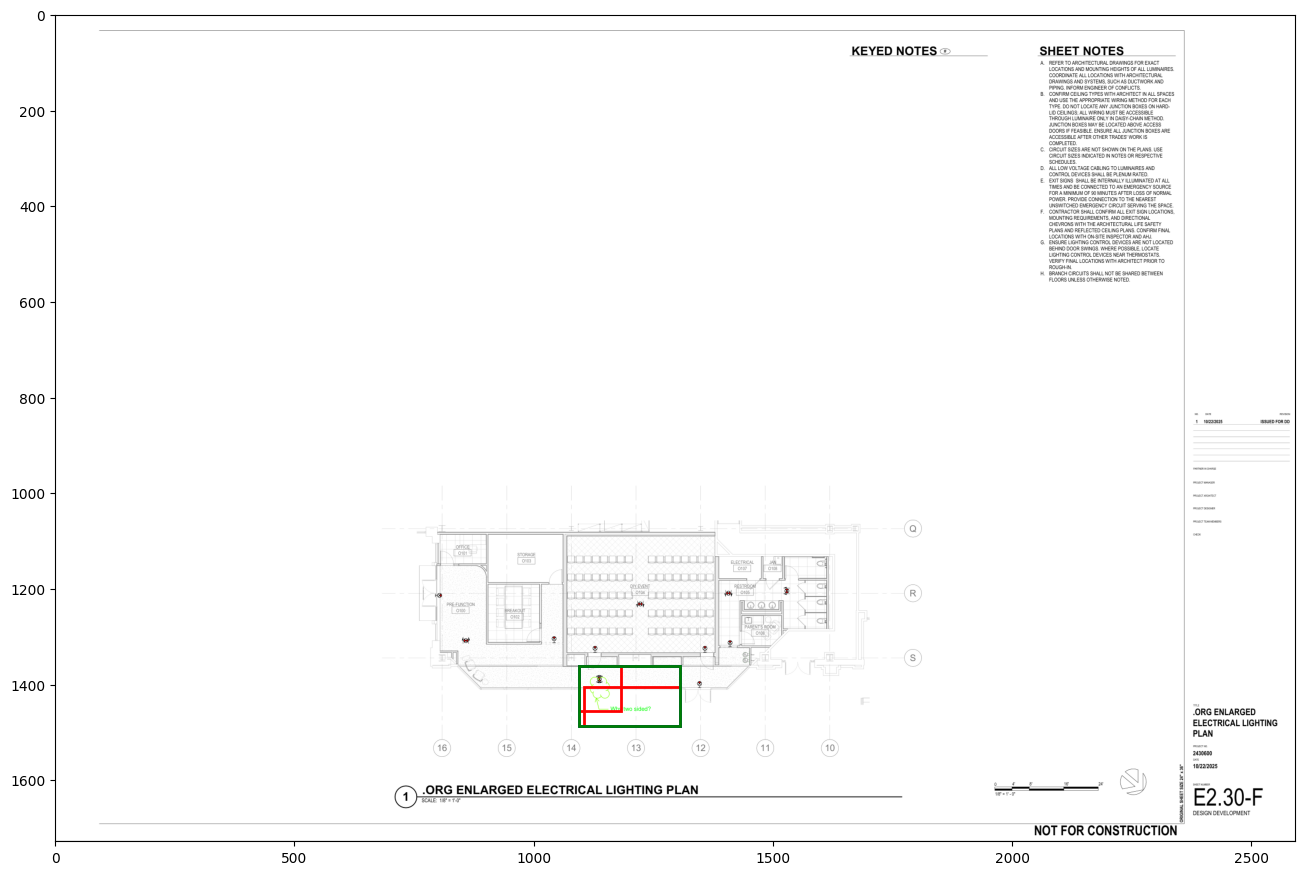

In [14]:
import matplotlib.pyplot as plt
from matplotlib import patches


fig,ax = plt.subplots(figsize=(16,25))

ax.imshow(page.get_pixmap().pil_image())


for annot in annots:
    bbox = MyRect(annot.apn_bbox).expand_rect(pix=18)

    patch = patches.Rectangle(bbox[0:2], bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor='r', facecolor='none')

    ax.add_patch(patch)

for boundary_rect in boundary_rects:
    patch = patches.Rectangle(boundary_rect.tl, boundary_rect.width, boundary_rect.height, linewidth=2, edgecolor='b', facecolor='none')

    ax.add_patch(patch)

    
for boundary_rect in screenshot_rects:
    patch = patches.Rectangle(boundary_rect.tl, boundary_rect.width, boundary_rect.height, linewidth=2, edgecolor='g', facecolor='none')

    ax.add_patch(patch)

In [15]:
screenshot_dict = {rect: {"annots": [], "authors": set(), "last_modified": -1, "portrait": True} for rect in screenshot_rects}

for annot in annots:
    for screenshot_rect in screenshot_dict.keys():
        if annot.apn_bbox.intersects(screenshot_rect):
            screenshot_dict[screenshot_rect]["annots"].append(annot)
            screenshot_dict[screenshot_rect]["authors"].add(annot.info['title'])

            modif_time = datetime.datetime.strptime(annot.info['modDate'].replace("'", ""), r"D:%Y%m%d%H%M%S%z")

            if screenshot_dict[screenshot_rect]["last_modified"] == -1 or modif_time.timestamp() > screenshot_dict[screenshot_rect]["last_modified"].timestamp():
                screenshot_dict[screenshot_rect]["last_modified"] = modif_time

            if screenshot_rect.width > screenshot_rect.height:
                screenshot_dict[screenshot_rect]["portrait"] = False
                

screenshot_dict

{Rect(1094.183349609375, 1360.94921875, 1306.5196533203125, 1486.14208984375): {'annots': ['Polygon' annotation on page 9 of c:\Users\BenjaminAnderson\OneDrive - db Engineering\Documents\Matt task - gathering screenshots\SAMPLE DDSet_Electrical.pdf,
   'FreeText' annotation on page 9 of c:\Users\BenjaminAnderson\OneDrive - db Engineering\Documents\Matt task - gathering screenshots\SAMPLE DDSet_Electrical.pdf],
  'authors': {'MattNielsen'},
  'last_modified': datetime.datetime(2025, 12, 16, 13, 16, 24, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=57600))),
  'portrait': False}}

In [16]:
# "D:20251216 131523-08'00'"

ts = datetime.datetime.strptime(annot.info['modDate'].replace("'", ""), r"D:%Y%m%d%H%M%S%z")

ts.strftime("%Y-%m-%d")

'2025-12-16'

In [17]:
output = pymupdf.open()

In [18]:
new_page = output.new_page()

In [ ]:
page_size = pymupdf.paper_sizes()['letter']

for screenshot in screenshot_dict.keys():
    pass

screenshot_dict[screenshot]

if screenshot_dict[screenshot]["portrait"]:
    new_page = output.new_page(width=page_size[0], height=page_size[1])
else:
    new_page = output.new_page(width=page_size[1], height=page_size[0])


In [20]:
new_page.insert_image(Rect((36,36),screenshot.width, screenshot.height), pixmap = page.get_pixmap(clip=screenshot,dpi=144))

7

In [21]:
new_page.insert_text((screenshot.width, screenshot.height), "I'm putting stuff here, how does that work?")

1

In [22]:
output.save("output.pdf")